# Modelos del lenguaje a partir de n-gramas

La estimación de modelos del lenguaje busca encontrar la probabilidad de una palabra dada su historia. En el caso de los bigramas, se asume la propiedad de Markov y se toma únicamente el elemento inmediatamente anterior. En el caso de modelos de n-gramas, con $n>2$, la palabra depende de más elementos anteriores.
Así, en el modelo de trigramas, se toma en cuenta las dos palabras anteriores. En el caso de 4-gramas, se toma en cuenta los 3 elementos anteriores. Y en general, para un modelo de n-gramas, se toma en cuenta los $n-1$ elementos anteriores. El modelo del lenguaje, entonces, se define como:

$$\mu = (\Sigma, A, \Pi)$$

donde $\Sigma$ es el vocabulario, $A$ es un tensor que guarda las probabilidades de transiciones y $\Pi$ guarda las probabilidades iniciales.

A continuación, estimamos modelos del lenguaje para un corpus.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from itertools import chain
from re import sub

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.strip().split()]

### Preprocesamiento del corpus

Para estimar las probabilidades, necesitamos un corpus. Procesaremos a preprocesarlo. En este caso, eliminamos signos de puntuaciónn y caracteres no alfanuméricos. Se debe señalar, que en muchos casos, se conservan los signos de puntuación como elementos pertenencientes al vocabulario. Esto con el objetivo de generar lenguaje escrito que preserve estos signos. Dado que esto no es ahora nuestra principal preocupación, eliminamos estos signos.

In [2]:
#Se abre el corpus, se limpia y se obtiene cada una de las líneas en éste
corpus = sub(r'[^\w\s]','', '\n'.join(open('corpus.es.txt','r', encoding='utf8').read().lower().strip().split('.')) ).split('\n')

#Se remueven las cadenas vacías
while("" in corpus): 
    corpus.remove("")
    
print(corpus[:10])

['comparación con otros modelos', 'como hemos señalado anteriormente los modelos implicacionales de wp muestran ventajas metodológicas al tomar a la palabra como unidad mínima de análisis', ' la asignación de rasgos morfosintácticos sólo se da en la palabra completa ninguna unidad formal menor a la palabra contiene rasgos ni características morfosintácticas', ' esta perspectiva evita una búsqueda exhaustiva de patrones segmentales que no necesariamente forman parte de la realidad lingüística', ' de esta forma el marco implicacional deja de lado discusiones teóricas como la pertinencia de la vocal temática o las variaciones de tema verbal', ' ', '\tacerca la flexión verbal del español los enfoques clásicos han dado gran peso a una discusión sobre la precisión de diferentes lindes segmentales y la asignación pertinente de rasgos esto es la estructura verbal de la palabra', ' el marco implicacional propuesto tiene poco interés en la estructura interna de la palabra y se concentra más en e

En primer lugar, tomaremos una parte del corpus y obtendremos los corpus de entrenamiento y de evaluación. En este caso, tomaremos el $70\%$ de los datos para estimar el modelo, mientras que el $30\%$ restante será parte de la evaluación, es decir, se utilizará para calcular la entropía (o, en otros casos, la perplejidad).

In [3]:
corpus = corpus[:100]

#Se obtiene el corpus de entrenamiento y evaluación
train_data, test_data = train_test_split(corpus, test_size=0.3)

print(len(train_data))
print(len(test_data))

70
30


A continuación, nos encargamos de pasar las cadenas de palabras a cadenas de índices numéricos. En este sentido, utilizaremos enteros para estimar el modelo. Crearemos dos diccionarios: uno que va toma una palabra y lo convierte en un índice (este nos servirá para acceder a las probabilidades en el modelo) y otro que tome los índices y los lleve a la palabra (este diccionario nos ayudará a recuperar los datos textuales a partir de los índices en el modelo).

In [4]:
#Llamamos la funcion para crear el vocabulario
voc = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(train_data,voc))

print(cads_idx[:3])
print(voc)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1, 17, 18, 19, 20, 21, 22, 1, 23, 24, 18, 25, 26, 27, 1, 28, 3, 18, 1, 29], [30, 31, 32, 33, 34, 35, 36, 37, 1, 28, 38, 18, 1, 29, 22, 39, 40, 41, 37, 30, 42, 18, 1, 43, 18, 6, 44, 13, 45, 18, 46, 47, 48, 28, 49, 27, 50, 51, 52, 18, 53, 54], [55]]
defaultdict(<function vocab.<locals>.<lambda> at 0x7f5a566a4af0>, {'acerca': 0, 'la': 1, 'flexión': 2, 'verbal': 3, 'del': 4, 'español': 5, 'los': 6, 'enfoques': 7, 'clásicos': 8, 'han': 9, 'dado': 10, 'gran': 11, 'peso': 12, 'a': 13, 'una': 14, 'discusión': 15, 'sobre': 16, 'precisión': 17, 'de': 18, 'diferentes': 19, 'lindes': 20, 'segmentales': 21, 'y': 22, 'asignación': 23, 'pertinente': 24, 'rasgos': 25, 'esto': 26, 'es': 27, 'estructura': 28, 'palabra': 29, 'el': 30, 'marco': 31, 'implicacional': 32, 'propuesto': 33, 'tiene': 34, 'poco': 35, 'interés': 36, 'en': 37, 'interna': 38, 'se': 39, 'concentra': 40, 'más': 41, 'análisis': 42, 'estructuración': 43, 'paradigmas': 44, 'par

Para completar el vocabulario, agregaremos los símbolos de BOS (Beginning Of String) y EOS (End Of String). Asimismo, añadiremos estos símbolos acada cadena en el entrenamiento, de tal forma que las cadenas sean de la forma:

$$<BOS> w_1 ... w_k <EOS>$$

De esta forma, podremos obtener probabilidades inciales y transiciones terminales (aquellas que van hacía el símbolo de termino EOS).

Asimismo, obtenemos el diccionario que nos servirá para recuperar las palabras dado los índices.

In [5]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(voc.values())+2
EOS_IDX = max(voc.values())+1

#Se agregan estas etiqeutas al vocabulario
voc[EOS] = EOS_IDX
voc[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

#Diccionario de índice : palabra
words = {idx: w for w,idx in voc.items()}

print(cadenas[:3])
print(len(cadenas))
print(EOS_IDX, BOS_IDX)

[[394, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1, 17, 18, 19, 20, 21, 22, 1, 23, 24, 18, 25, 26, 27, 1, 28, 3, 18, 1, 29, 393], [394, 30, 31, 32, 33, 34, 35, 36, 37, 1, 28, 38, 18, 1, 29, 22, 39, 40, 41, 37, 30, 42, 18, 1, 43, 18, 6, 44, 13, 45, 18, 46, 47, 48, 28, 49, 27, 50, 51, 52, 18, 53, 54, 393], [394, 55, 393]]
70
393 394


### Estimación del modelo de n-gramas

Una vez preprocesadas las cadenas podemos pasar a estimar el modelo. Para esta estimación, tomaremos en cuenta dos parámetros:



*   El tamaño de n-gramas; es decir, qué tantos elementos previos consideraremos para estimar la probabilidad de que ocurra una palabra.
*   El elemento $\lambda$ para estimar la probabilidad con smoothing de Lidstone. En este sentido, dado un n-grama $w_{i-n+1} ... w_{i-1} w_i$ estimaremos la probabilidad como:

$$p(w_i|w_{i-1}...w_{i-n+1}) = \frac{fr(w_{i-n+1} ... w_{i-1} w_i) + \lambda}{fr(w_{i-n+1} ... w_{i-1}) + \lambda N}$$

donde $N$ es el tamaño del vocabulario.


In [6]:
def get_model(cadenas, n=2, l=1.0):
    #Se crean los bigramas
    bigrams = chain(*[ zip(*[cad[i:] for i in range(n)] ) for cad in cadenas] )

    #Se obtiene la frecuencia de cada bigrama
    frec_grams = Counter(bigrams)
    
    #Obtenemos el tamaño del vocabulario (menos EOS y BOS)
    N = len(voc) -2
    #Determinamos las dimensiones del tensor de transciones
    #En la palabra condicionada consideraremos al elemento EOS
    dim = (N,)*(n-1) + (N+1,)

    #Tensor de transiciones
    A = np.zeros(dim)
    #Probabilidades iniciales
    Pi = np.zeros(N)
    
    #Frecuencias
    for bigram,frec in frec_grams.items():
      #Se llena el tensor de transiciones con frecuencias
      if bigram[0] != BOS_IDX:
          A[bigram] = frec
      #Se onbtienen las frecuencias de iniciales
      elif bigram[0] == BOS_IDX and bigram[1] != EOS_IDX:
          Pi[bigram[1]] = frec
          
    #A partir de las frecuencias, se obtienen las probabilidades
    #Se considera un parámetro l de smoothing de Lidstone
    for h,b in enumerate(A):
      A[h] = ((b+l).T/(b+l).sum(n-2)).T
    
    #Probabilidad de iniciales  
    Pi = (Pi+l)/(Pi+l).sum(0)
    
    return A, Pi

En primer lugar, podemos estimar un modelo de trigramas con $\lambda =1$, es decir, con smoothing Laplaciano.

In [7]:
%%time
#Modelo de trigramas
mu_3g_lap = get_model(cadenas, n=3, l=1.0)

#Tamaño del tensor de transicion
print(mu_3g_lap[0].shape)
#Suma de probabilidades
print(mu_3g_lap[0].sum(2))

(393, 393, 394)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
CPU times: user 385 ms, sys: 247 ms, total: 632 ms
Wall time: 642 ms


De igual forma, podemos obtener un modelo de bigramas también con smoothing Laplaciano.

In [8]:
%%time
#Modelo de bigramas
mu_2g_lap = get_model(cadenas, n=2, l=1.0)

#Tamaño del tensor de transicion
print(mu_2g_lap[0].shape)
#Suma de probabilidades
print(mu_2g_lap[0].sum(1))

(393, 394)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

### Aplicaciones de los modelos

Una vez estimados estos modelos del lenguaje, podemos ver sus diferentes aplicaciones para algunas de las tareas típicas: determinar la probabilidad de una cadena, predecir la palabra siguiente y generar texto.

Para determinar la probabilidad, utilizaremos la función:

$$p(w_1 ... w_k) = \prod_{i=1}^k p(w_i|w_{i-1} ... w_{i-n+1})$$

Dado que las cadenas pueden extenderse y las probabilidades son pequeñas, es posible que la probabilidad se haga tan pequeña que aparezca como un cero. Para evitar esto, utilizaremos probabilidad logarítimicada, dada por:

$$\log p(w_1 ... w_k) = \sum_{i=1}^k \log p(w_i|w_{i-1} ... w_{i-n+1})$$

In [9]:
#Probabilidad logarítimica
def prob_str(string, mu):
    #Elementos del modelo
    A, Pi = mu
    #n-gramas
    n = len(A.shape)
    #Palabras de la cadena
    sent = [voc[w] for w in string.split()]
    
    #Probabilidad inicial
    try:
      p = np.log(Pi[voc[sent[0]]])
    #OOV
    except:
      p = 0.0
    
    #Obtener n-gramas de la cadena
    grams = list(zip(*[sent[i:] for i in range(n)]))
    #Probabilidad de n-gramas
    for gram in grams:
        try:
          p += np.log(A[gram])
        #OOV
        except:
          p += 0.0
    
    return p

Podemos probar esta estimación sobre cadenas. Para obtener la probabilidad exacta, sólo basta elevar a la exponencial la probabilidad logarítmica.

In [10]:
print('Probabilidad para la cadena:', train_data[0])
print('\t Modelo trigramas:', np.exp(prob_str(train_data[5], mu_3g_lap)))
print('\t Modelo bigramas:', np.exp(prob_str(train_data[5], mu_2g_lap)))

Probabilidad para la cadena: 	acerca la flexión verbal del español los enfoques clásicos han dado gran peso a una discusión sobre la precisión de diferentes lindes segmentales y la asignación pertinente de rasgos esto es la estructura verbal de la palabra
	 Modelo trigramas: 1.0
	 Modelo bigramas: 1.0


Otra de las aplicaciones es la predicción de la palabra subsiguiente; para esto buscaremos:
  
$$\arg\max_w p(w_1 ... w_k w)$$

Es claro que la probabilidad logarítimica no afecta el resultado, es decir, se cumple la igualdad:

$$\arg\max_w p(w_1 ... w_k w) = \arg\max_w \log p(w_1 ... w_k w)$$

In [11]:
def next_word(string, mu):
    #n-grams
    history = len(mu[0].shape)-1
    #Palabras en la cadena
    sent = [voc[w] for w in string.split()]
    #Los elementos previos
    prev_gram = tuple(sent[-history:])
    #Se obtiene probabilidad d ela cadena previa
    p = prob_str(string, mu)
    #Se obtienen las probabilidades de los elementps subsiguientes
    #Se obtiene el máximo de estas probabilidades
    next = np.argmax(p + np.log(mu[0][prev_gram]))
    
    return words[next]

In [12]:
print(next_word('en el español', mu_3g_lap))
print(next_word('en el español', mu_2g_lap))

muestra
<EOS>


Finalmente, podemos iterar la función anterior para producir una función de generación del lenguaje. El algoritmo se detendra cuando encuentre el símbolo EOS, o despúes de producir 100 palabras.

In [13]:
def generate(string, mu):
    #Inicialización palabra
    w = ''
    #Inicialización cadena generada
    str_gen = string
    
    i = 0
    #Mientras no se prediga EOS
    while w != '<EOS>':
        #Obtener la palabra subsiguiente
        w = next_word(str_gen, mu)
        #Se añade a la cadena generada
        str_gen += ' ' + w
        
        i += 1
        #Se deteiene el algoritmo si ha alcanzado 100 iteraciones
        if i == 100:
            break
        
    return str_gen
        

In [14]:
print('Modelo trigramas:', generate('el español', mu_3g_lap))
print('Modelo bigramas:', generate('el español', mu_2g_lap))

Modelo trigramas: el español muestra una combinación de ta a este morfema dejando de lado el modo o bien atribuyéndose a la palabra verbal del español <EOS>
Modelo bigramas: el español <EOS>


### Evaluación de los modelos

Finalmente, podemos evaluar los modelos a partir de su entropía. Esta se determina en un corpus de evaluación, que nunca debió ser visto por el entrenamiento. Calcularemos la entropía como:

$$H(p) = -\frac{1}{K} \sum_{i=1}^k p(w_1 ... w_k)$$

A partir de la entropía podríamos caluclar la perplejidad como $2^{H(p)}$. (Debe notarse que, como estamos estimando probabilidades logarítmicas, no hará falta obtener un logaritmo en esta función).

In [15]:
def get_entropy(mu):
  #Inicialización Entropía
  H = 0.0
  #Evaluamos en el corpus de evaluación
  for cad in test_data:
      #Probabilidad de la cadena
      logp_cad = prob_str(cad, mu)
      #Número de palabras
      M = len(cad.split())
      #Obtenemos la entropía cruzada de la cadena
      H -= logp_cad/(M+1e-100)       

  return H/len(test_data) 

In [22]:
print('--Entropía--')
print('\t Modelo de bigramas:', 2**get_entropy(mu_2g_lap))
print('\t Modelo de trigramas:', 2**get_entropy(mu_3g_lap))

--Entropía--
	 Modelo de bigramas: 3.5923932771091
	 Modelo de trigramas: 2.7408636864829425


En general, los modelos de trigramas muestran una entropía más baja (o perplejidad más baja) (Jurafsky y Martin, 2018). También podemos estimar cuál es el mejor parámetro en la probabilidad de Lidstone:

In [17]:
%%time
trig_entropy = []
big_entropy = []

for k in range(1,200):
  #Parámetro
  par = k/100
  #Entropía del modelo de 2-gramas
  ent2 = get_entropy(get_model(cadenas, n=2, l=par))
  #Entropía del modelo 3-gramas
  ent3 = get_entropy(get_model(cadenas, n=3, l=par))
  
  trig_entropy.append([par, ent3])
  big_entropy.append([par, ent2])

CPU times: user 2min 46s, sys: 3min 41s, total: 6min 27s
Wall time: 6min 27s


Visualizamos cómo se comporta la entropía con respecto al parámetro $\lambda$ en un modelo de trigramas.

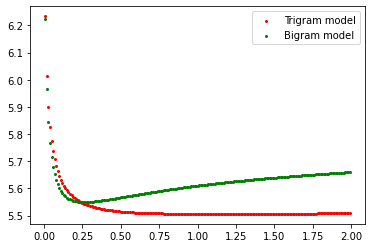

In [18]:
trig_entropy = np.array(trig_entropy)
big_entropy = np.array(big_entropy)

#Visualización del modelo
plt.scatter(trig_entropy[:,0], trig_entropy[:,1], color='r', s=4, label='Trigram model')
plt.scatter(big_entropy[:,0], big_entropy[:,1], color='g', s=4, label='Bigram model')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Y podemos utilizar este parámetro para estimar un modelo de trigramas.

In [19]:
#Parámetro óptimo
lamb = trig_entropy[:,0][np.argmin(trig_entropy[:,1])]
print('Lambda óptimo:', lamb)

#Estimación del modelo
mu_3g_lid = get_model(cadenas, n=3, l=lamb)

#Ejemplo de probabilidad
print('Probabilidad de la cadena:', train_data[5])
print('\t', np.exp(prob_str(train_data[5], mu_3g_lid)))

Lambda óptimo: 1.12
Probabilidad de la cadena: 			basevtpsd
	 0.0018214936247723135
